In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [2]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

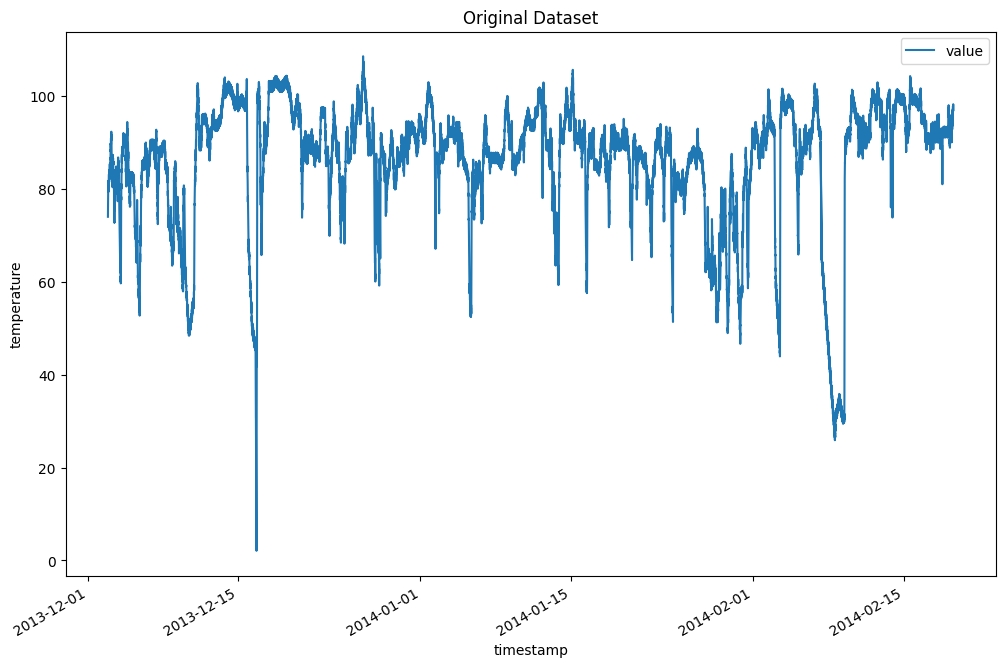

In [3]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [4]:
data['label'] = 1
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


In [5]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 0

In [6]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2013-12-02 21:15:00,73.967322,1
1,2013-12-02 21:20:00,74.935882,1
2,2013-12-02 21:25:00,76.124162,1
3,2013-12-02 21:30:00,78.140707,1
4,2013-12-02 21:35:00,79.329836,1
...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1
22691,2014-02-19 15:10:00,97.804168,1
22692,2014-02-19 15:15:00,97.135468,1
22693,2014-02-19 15:20:00,98.056852,1


In [7]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,1,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,1,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,1,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,1,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,1,2,12,21.583333,0,0


In [8]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [9]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [10]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [11]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,label,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,12,21.250000,0,0,-23,13860189
1,74.935882,1,2,12,21.333333,0,0,-23,13860192
2,76.124162,1,2,12,21.416667,0,0,-23,13860195
3,78.140707,1,2,12,21.500000,0,0,-23,13860198
4,79.329836,1,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,19,2,15.083333,2,0,49,13928223
22691,97.804168,1,19,2,15.166667,2,0,49,13928226
22692,97.135468,1,19,2,15.250000,2,0,49,13928229
22693,98.056852,1,19,2,15.333333,2,0,49,13928232


In [12]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,73.967322,1,21.250000,-23,13860189,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,74.935882,1,21.333333,-23,13860192,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,76.124162,1,21.416667,-23,13860195,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,78.140707,1,21.500000,-23,13860198,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,79.329836,1,21.583333,-23,13860201,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,15.083333,49,13928223,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,97.804168,1,15.166667,49,13928226,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,97.135468,1,15.250000,49,13928229,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,98.056852,1,15.333333,49,13928232,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [14]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'gap_holiday', 't', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'month_0', 'month_1', 'month_2', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'holiday_0', 'holiday_1'],
      dtype='object')


In [15]:
# Splitting to train and test
test_ratio = 0.3
tr_data = data.iloc[int(len(data) * 0.25): int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [16]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [17]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [18]:
tr_data_scaled

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
5673,-0.072863,1,0.284115,-1.392295,-1.732601,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5674,0.028166,1,0.296123,-1.392295,-1.732261,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5675,-0.253039,1,0.308131,-1.392295,-1.731921,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5676,-0.233108,1,0.320138,-1.392295,-1.731582,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5677,-0.119571,1,0.332146,-1.392295,-1.731242,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.099055,1,1.677012,1.841695,1.731745,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.089198,1,1.689020,1.841695,1.732085,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.117255,1,1.701027,1.841695,1.732425,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.004729,1,1.713035,1.841695,1.732765,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [19]:
tst_data_scaled

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
15886,0.100616,1,-1.721176,1.957195,1.733444,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15887,-0.136284,1,-1.709168,1.957195,1.733784,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15888,0.043977,1,-1.697160,1.957195,1.734124,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15889,0.095345,1,-1.685153,1.957195,1.734464,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15890,-0.061215,1,-1.673145,1.957195,1.734803,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,1.382210,1,0.440216,4.613686,4.045274,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,1.331855,1,0.452223,4.613686,4.045613,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,1.243532,1,0.464231,4.613686,4.045953,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,1.365229,1,0.476239,4.613686,4.046293,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [20]:
train = tr_data_scaled[tr_data_scaled.label != 0]
train= train.drop(columns=['label'])
train

,value,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,day_5,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
5673,-0.072863,0.284115,-1.392295,-1.732601,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5674,0.028166,0.296123,-1.392295,-1.732261,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5675,-0.253039,0.308131,-1.392295,-1.731921,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5676,-0.233108,0.320138,-1.392295,-1.731582,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
5677,-0.119571,0.332146,-1.392295,-1.731242,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.099055,1.677012,1.841695,1.731745,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.089198,1.689020,1.841695,1.732085,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.117255,1.701027,1.841695,1.732425,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.004729,1.713035,1.841695,1.732765,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [21]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [22]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [23]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [24]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [25]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [26]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [27]:
print(input_shape)

(47,)


In [28]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 15)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,824 (7.12 KB)

 Trainable params: 1,824 (7.12 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │         1,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,496 (5.84 KB)

 Trainable params: 1,496 (5.84 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [63]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=150,
                        batch_size=128)

Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_2    │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2173.0679
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2029.9496
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 1919.1257
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 1805.0581
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1689.9902
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 1571.5381
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1442.3812
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1308.4199
Epoch 9/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1186.1403
Epoch 10/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 1069.6442
Epoch 11/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 965.1863
Epoch 12/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 878.2581
Epoch 13/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 818.9764  
Epoch 14/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 777.7787
Epoch 15/150
80/80 ━━━━━━━━━━

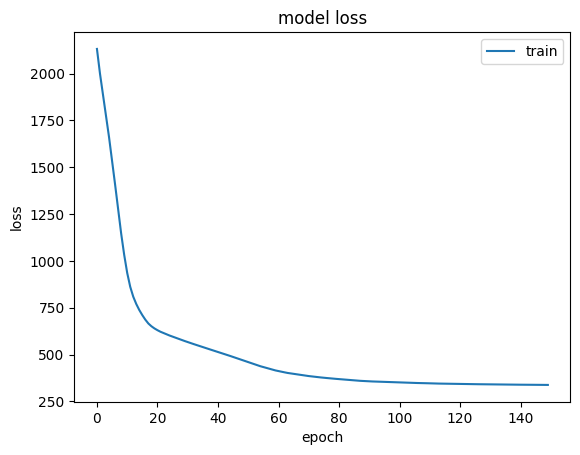

In [64]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [65]:
train_pred = vae_model.predict(train)[0]

320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


In [66]:
mae_vector = get_error_term(train_pred, train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.054354362189769745
median error 0.053137458860874176
99Q: 0.1259217113256453
setting threshold on 0.1259217113256453 


In [67]:
#Actual ratio of anomalies 
ratio=1-np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.1665442796299016


In [68]:
pred = vae_model.predict(test)[0]
mae_vector = get_error_term(pred, test, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

  1/213 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Avg error 0.21669508516788483
median error 0.2153228372335434
99Q: 0.38648225903511046


0.9629901600822441

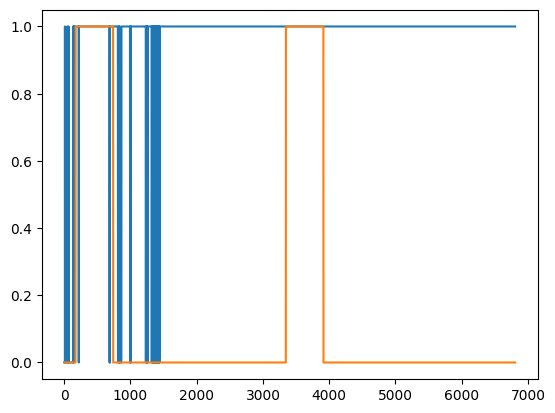

In [69]:
plt.plot(anomalies)
plt.plot(np.logical_not(labels_of_test))

In [70]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(labels_of_test, anomalies))

              precision    recall  f1-score   support

           0       0.02      0.00      0.01      1134
           1       0.83      0.96      0.89      5675

    accuracy                           0.80      6809
   macro avg       0.42      0.48      0.45      6809
weighted avg       0.69      0.80      0.74      6809



In [71]:
encoded = encoder.predict(test)

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transform = pca.fit_transform(encoded)

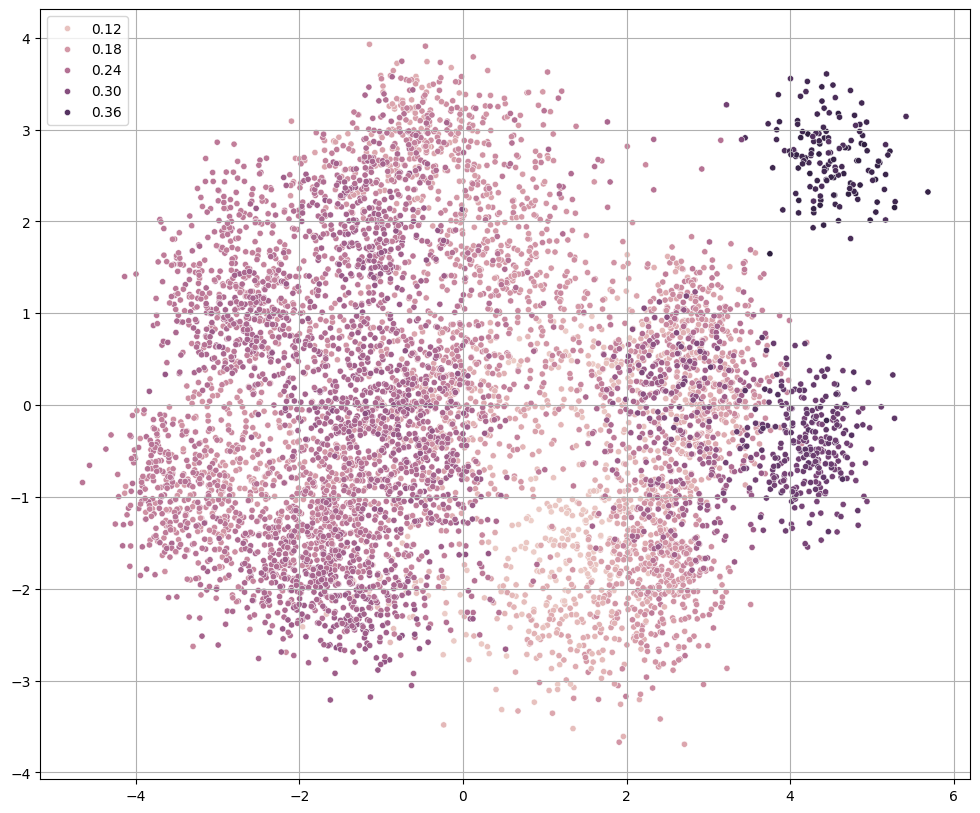

In [73]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

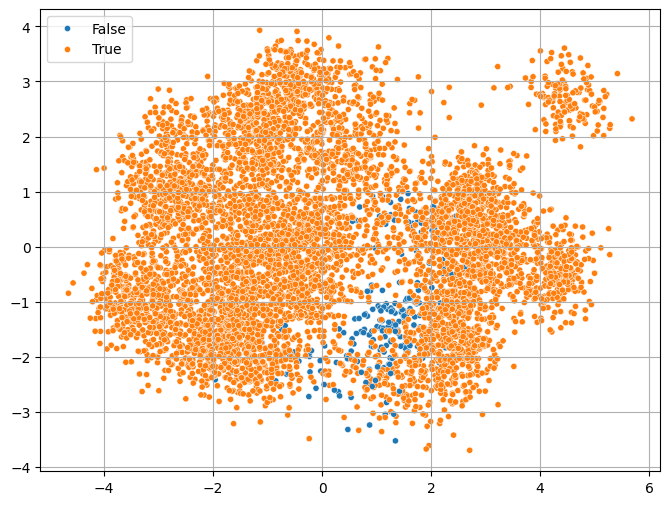

In [74]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

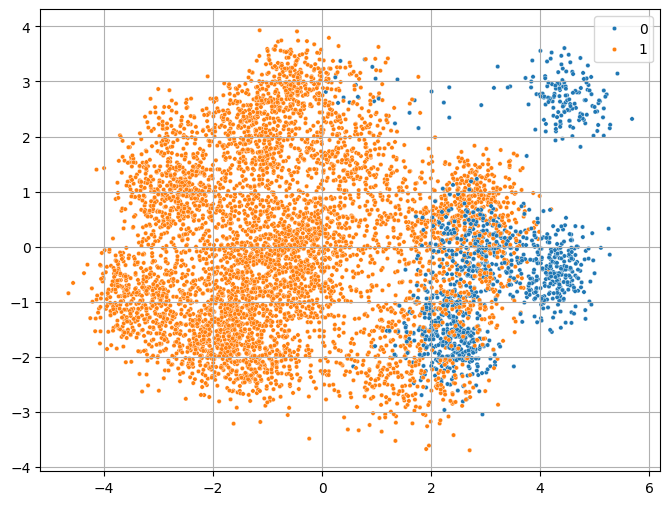

In [75]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=10, hue=labels_of_test)
plt.grid()
plt.show()

In [76]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]
tst_data

,timestamp,value,label,anomaly
15886,2014-01-27 00:05:00,88.482330,1,False
15887,2014-01-27 00:10:00,86.688731,1,False
15888,2014-01-27 00:15:00,88.053503,1,False
15889,2014-01-27 00:20:00,88.442419,1,False
15890,2014-01-27 00:25:00,87.257083,1,False
...,...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1,True
22691,2014-02-19 15:10:00,97.804168,1,True
22692,2014-02-19 15:15:00,97.135468,1,True
22693,2014-02-19 15:20:00,98.056852,1,True


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

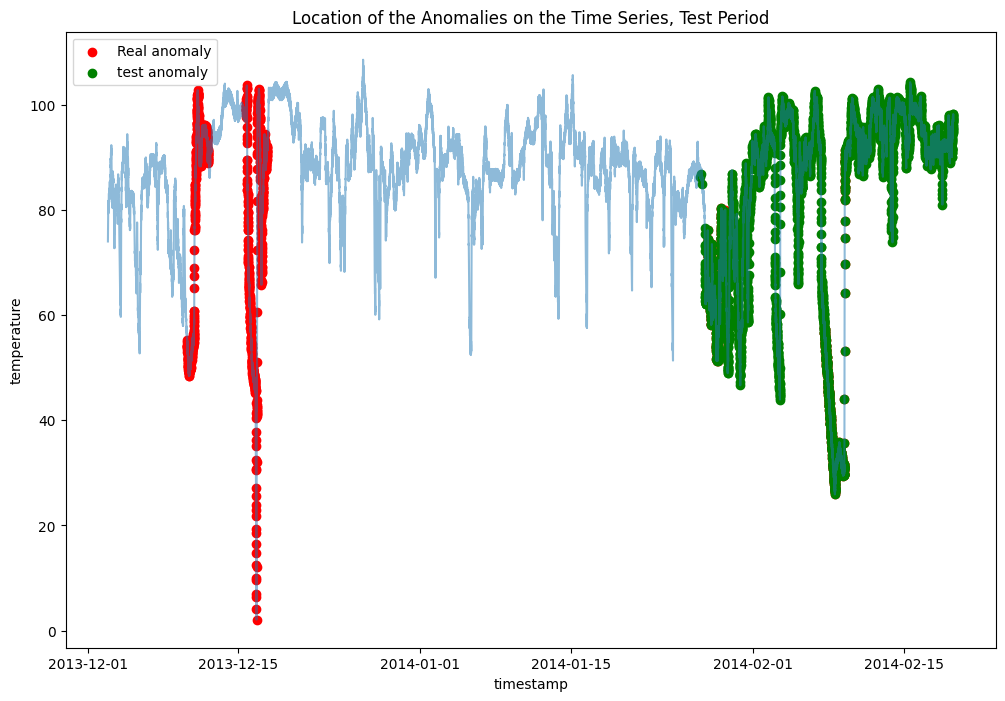

In [77]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==0, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], alpha=.5)
ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')

ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")